#Make NLP Model with TensorFlow

In this project, I'll try to make MOdel for NLP using Tensorflow and LSTM (Long Short Term Memories)

The Datasets that I used for this project is "bbc-text.csv" from Kaggle

##1. Import Libbraries

Import all libbraries used for this project

In [ ]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

## 2. Import Dataset

First, I'll upload the dataset and make a Dataframe from that dataset using Pandas Dataframe.

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rizki1994","key":"e2c181da4daa4a83ca5c75260be052ea"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d yufengdev/bbc-fulltext-and-category

  0% 0.00/1.83M [00:00<?, ?B/s]
100% 1.83M/1.83M [00:00<00:00, 143MB/s]


In [ ]:
import os
import zipfile
local_zip= '/content/bbc-fulltext-and-category.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
df = pd.read_csv('bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


From the info, there are 2225 row of data from this dataset.

##3. Cleaning Dataset

To improve my model's accuracy, I'll eliminate unnecessary symbols, stopwords, and unwanted string from the dataset using nltk.

In [ ]:
df['text'][11]

'virgin blue shares plummet 20% shares in australian budget airline virgin blue plunged 20% after it warned of a steep fall in full year profits.  virgin blue said profits after tax for the year to march would be between 10% to 15% lower than the previous year.  sluggish demand reported previously for november and now december 2004 continues   said virgin blue chief executive brett godfrey. virgin blue  which is 25% owned by richard branson  has been struggling to fend off pressure from rival jetstar. it cut its full year passenger number forecast by  approximately 2.5% . virgin blue reported a 22% fall in first quarter profits in august 2004 due to tough competition. in november  first half profits were down due to slack demand and rising fuel costs. virgin blue was launched four years ago and now has roughly one third of australia s domestic airline market. but the national carrier  qantas  has fought back with its own budget airline  jetstar  which took to the skies in may 2004. syd

from df['text'][11], there are some symbols like %, -, and there are some stopwords like 'and', 'has been', 'in', etc. I'll try to remove that string from the dataset.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))
space = re.compile('[/(){}\[\]\|@,;]')
symbols= re.compile('[^0-9a-z #+_]')

def clean_text(text):
    text = text.lower()
    text = space.sub(' ', text) #substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = symbols.sub('', text) #substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in stop_words) # remove stopwors from text
    return text

df['text']=df['text'].apply(clean_text)

In [ ]:
df['text'][11]

'virgin blue shares plummet 20 shares australian budget airline virgin blue plunged 20 warned steep fall full year profits virgin blue said profits ta year march would 10 15 lower previous year sluggish demand reported previously november december 2004 continues said virgin blue chief eecutive brett godfrey virgin blue 25 owned richard branson struggling fend pressure rival jetstar cut full year passenger number forecast approimately 25 virgin blue reported 22 fall first quarter profits august 2004 due tough competition november first half profits due slack demand rising fuel costs virgin blue launched four years ago roughly one third australia domestic airline market national carrier qantas fought back budget airline jetstar took skies may 2004 sydneylisted virgin blue shares recovered slightly close 12 wednesday shares major shareholder patrick corporation owns 46 virgin blue dropped 31 close'

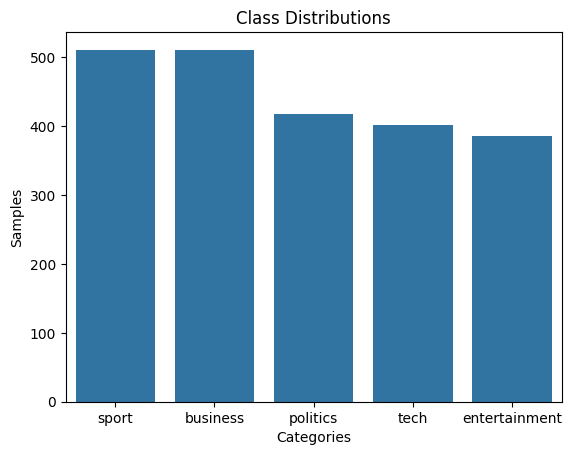

In [ ]:
import seaborn as sns

x = df.category.value_counts()
sns.barplot(x=x.index, y=x)
plt.gca().set_title('Class Distributions')
plt.gca().set_ylabel('Samples')
plt.gca().set_xlabel('Categories')
plt.show()

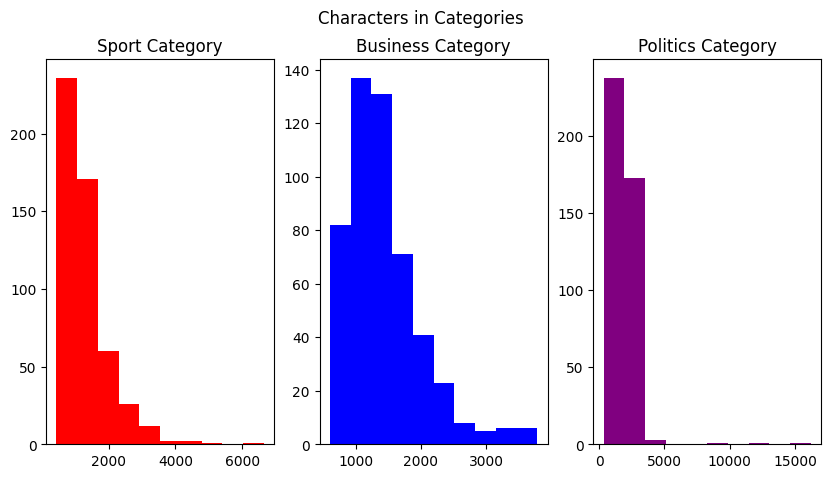

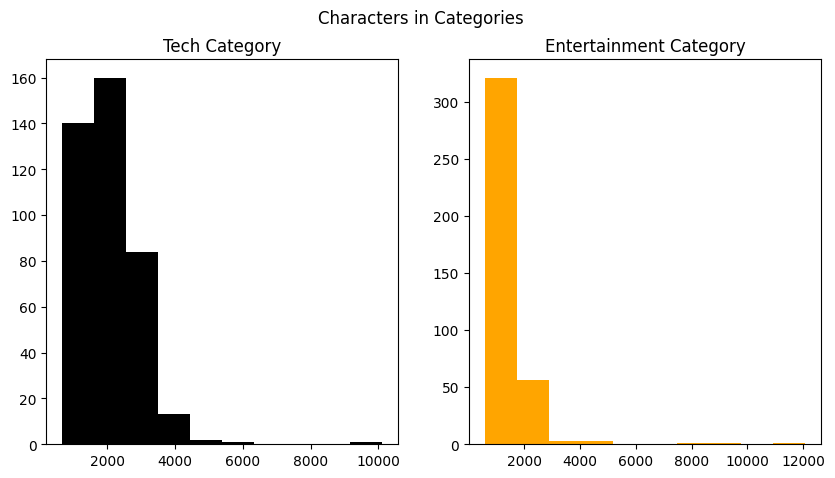

In [ ]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
count_sport = df[df['category']=='sport']['text'].str.len()
ax1.hist(count_sport, color='red')
ax1.set_title('Sport Category')

count_business = df[df['category']=='business']['text'].str.len()
ax2.hist(count_business, color='blue')
ax2.set_title('Business Category')

count_politics = df[df['category']=='politics']['text'].str.len()
ax3.hist(count_politics, color='purple')
ax3.set_title('Politics Category')
fig1.suptitle('Characters in Categories')

fig2, (ax4, ax5) = plt.subplots(1, 2, figsize=(10, 5))
count_tech = df[df['category']=='tech']['text'].str.len()
ax4.hist(count_tech, color='black')
ax4.set_title('Tech Category')

count_entertainment = df[df['category']=='entertainment']['text'].str.len()
ax5.hist(count_entertainment, color='orange')
ax5.set_title('Entertainment Category')
fig2.suptitle('Characters in Categories')

plt.show()

After cleaning there are no more symbols and stop words.

## 4. Using Callback Function

I'll implement a Callback Function, so my model training will be stopped after reaching desired accuracy, 91%.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs:{}):
    if(logs.get('accuracy')>0.91 and logs.get('val_accuracy')>0.91) :
      print("\n Akurasi sudah di atas 91%, hentikan training!")
      self.model.stop_training = True

lr = ReduceLROnPlateau(monitor='val_loss',
                       pattience=1,
                       factor=0.5,
                       verbose=1)

## 5. One Hot Encoding

To change the dataset into numerical data, I'll perform One Hot Encoding for my dataset using pd.get.dummies, and combine the result into main dataframe.

In [ ]:
category = pd.get_dummies(df.category)
df_baru = pd.concat([df,category], axis=1)
df_baru = df_baru.drop(columns='category')
df_baru

,text,business,entertainment,politics,sport,tech
0,tv future hands viewers home theatre systems p...,0,0,0,0,1
1,worldcom boss left books alone former worldcom...,1,0,0,0,0
2,tigers wary farrell gamble leicester say rushe...,0,0,0,1,0
3,yeading face newcastle fa cup premiership side...,0,0,0,1,0
4,ocean twelve raids bo office ocean twelve crim...,0,1,0,0,0
...,...,...,...,...,...,...
2220,cars pull us retail figures us retail sales fe...,1,0,0,0,0
2221,kilroy unveils immigration policy echatshow ho...,0,0,1,0,0
2222,rem announce new glasgow concert us band rem a...,0,1,0,0,0
2223,political squabbles snowball become commonplac...,0,0,1,0,0


## 6. Train and Test Data

Change all data into numerical data, and split the dataset for train and test data with ratio 0.2 or 20%. After that the data will be Tokenized, turn into sequences, and use pad_sequences.

In [ ]:
news = df_baru['text'].values
category = df_baru[['business','entertainment', 'politics', 'sport', 'tech']].values

In [ ]:
news_latih, news_test, category_latih, category_test = train_test_split(news, category, test_size=0.2, random_state=42)

In [ ]:
len(news_latih)

1780

In [ ]:
len(news_test)

445

After splitting, the data on news_test are 445 data. That's exactly 20% from total dataset 2225 data.

In [ ]:
tokenizer = Tokenizer(num_words=3000, oov_token='x')
tokenizer.fit_on_texts(news_latih)
tokenizer.fit_on_texts(news_test)

sekuens_latih = tokenizer.texts_to_sequences(news_latih)
sekuens_test = tokenizer.texts_to_sequences(news_test)

padded_latih = pad_sequences(sekuens_latih)
padded_test = pad_sequences(sekuens_test)

##7. Model

Make a Sequential model using Embedding and LSTM layers.
To prevent overfit for my model, I'll add Dropout layer with 0.2 value.

In [ ]:
model = tf.keras.Sequential([
         tf.keras.layers.Embedding(input_dim=3000, output_dim=16),
         tf.keras.layers.LSTM(64),
         tf.keras.layers.Dense(64, activation='relu'),
         tf.keras.layers.Dropout(0.5),
         tf.keras.layers.Dense(32, activation='relu'),
         tf.keras.layers.Dropout(0.5),
         tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

##8. Train Model

The model will be trained with 30 epochs.

In [ ]:
num_epochs = 70
history = model.fit(padded_latih,
                    category_latih,
                    epochs=num_epochs,
                    steps_per_epoch = 36,
                    validation_data = (padded_test, category_test),
                    validation_steps = 27,
                    verbose = 1,
                    callbacks=[lr, myCallback()]
                    )

Epoch 1/70
36/36 [==============================] - 16s 279ms/step - loss: 1.6089 - accuracy: 0.2096 - val_loss: 1.6061 - val_accuracy: 0.2202 - lr: 0.0010
Epoch 2/70
36/36 [==============================] - 7s 186ms/step - loss: 1.6012 - accuracy: 0.2180 - val_loss: 1.5843 - val_accuracy: 0.2202 - lr: 0.0010
Epoch 3/70
36/36 [==============================] - 7s 198ms/step - loss: 1.5612 - accuracy: 0.2528 - val_loss: 1.4133 - val_accuracy: 0.3079 - lr: 0.0010
Epoch 4/70
36/36 [==============================] - 5s 145ms/step - loss: 1.3085 - accuracy: 0.3798 - val_loss: 1.1037 - val_accuracy: 0.4112 - lr: 0.0010
Epoch 5/70
36/36 [==============================] - 6s 161ms/step - loss: 1.0712 - accuracy: 0.4989 - val_loss: 0.9800 - val_accuracy: 0.5393 - lr: 0.0010
Epoch 6/70
36/36 [==============================] - 6s 173ms/step - loss: 0.8684 - accuracy: 0.5494 - val_loss: 0.8404 - val_accuracy: 0.6112 - lr: 0.0010
Epoch 7/70
36/36 [==============================] - 6s 159ms/step - l

##9. Graphic

To visualize the accuracy history and loss history of my model training, I'll make graphic or plot using matplotlib.pyplot.

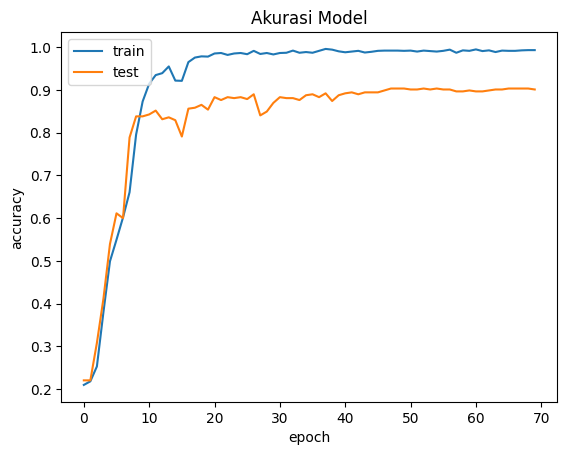

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

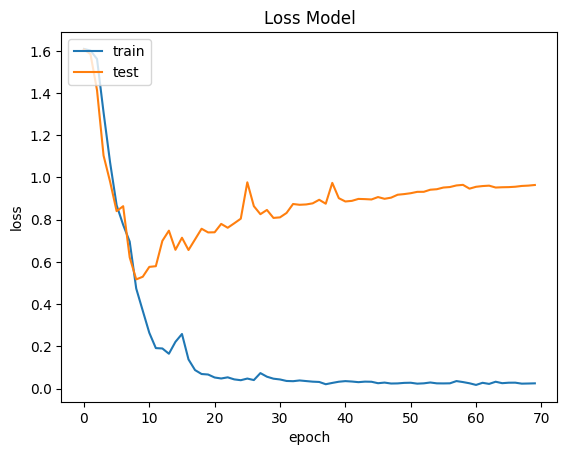

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()